## **1. Import libraries**

In [143]:
# Database connection
import mysql.connector
from mysql.connector import Error

# Environment variables
import os
from dotenv import load_dotenv

# Define paths
from pathlib import Path

# Load json files
import json

# DataFrame handling
import pandas as pd

# Time series analysis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Plot settings
sns.set_context("paper")
sns.set_style("darkgrid")

## **2. Database connection**

In [144]:
# Define current directory
root = Path().cwd().parent
department_capital_path = root / "config" / "department_capitals.json"
department_code_path = root / "config" / "department_code.json"

In [145]:
# Load and get environment variables
load_dotenv()
env_vars = {"DB_HOST": os.environ["DB_HOST"],
            "DB_PORT": os.environ["DB_PORT"],
            "DB_USER": os.environ["DB_USER"],
            "DB_NAME": os.environ["DB_NAME"],
            "DB_PASSWORD": os.environ["DB_PASSWORD"]}

In [146]:
# Define query
query = "SELECT * FROM clients"

# Database connection, query execution and fetch results
try:
    connection = mysql.connector.connect(
    host= env_vars["DB_HOST"],
    port= env_vars["DB_PORT"],
    user= env_vars["DB_USER"],
    password= env_vars["DB_PASSWORD"],
    database= env_vars["DB_NAME"]
    )
    if connection.is_connected():
        cursor = connection.cursor()
        cursor.execute(query)
        result = cursor.fetchall()
        print("Ok!")

except Error as ex:
    print(f"Error during connection {ex}")

finally:
    if connection.is_connected():
        connection.close()

Ok!


## **3. Create DataFrame from query result**

In [147]:
# Create DataFrame from result
df = pd.DataFrame(data= result, columns= ["id","period","status","city_client"])
df = df.set_index("id")
df.head()

,period,status,city_client
id,,,
1,2022-03-16 19:56:42,inactive,"Soracá, Boyacá"
2,2022-04-30 19:14:36,active,"Puerto Libertador, Córdoba"
3,2023-05-20 21:17:44,inactive,"Iles, Nariño"
4,2023-05-05 04:50:31,inactive,"Solita, Caquetá"
5,2022-02-14 05:17:56,active,San Andrés


In [148]:
# Check for data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 1 to 2000
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   period       2000 non-null   datetime64[ns]
 1   status       2000 non-null   object        
 2   city_client  2000 non-null   object        
dtypes: datetime64[ns](1), object(2)
memory usage: 62.5+ KB


## **4. Data transformation**

In [149]:
# Split city and department in client_city column
data = df.copy()
data[["city_client", "department_client"]] = data["city_client"].str.split(", ", expand= True)
data.head()

,period,status,city_client,department_client
id,,,,
1,2022-03-16 19:56:42,inactive,Soracá,Boyacá
2,2022-04-30 19:14:36,active,Puerto Libertador,Córdoba
3,2023-05-20 21:17:44,inactive,Iles,Nariño
4,2023-05-05 04:50:31,inactive,Solita,Caquetá
5,2022-02-14 05:17:56,active,San Andrés,None


In [150]:
# Assign D.C. department to Cundinamarca
data.loc[data["department_client"] == "D.C.", "department_client"] = "Cundinamarca"

In [151]:
# Map status column into 0 or 1
mapping_dict = {"active": 1,
                "inactive": 0} 

data["status"] = data["status"].map(mapping_dict)
data.head()

,period,status,city_client,department_client
id,,,,
1,2022-03-16 19:56:42,0,Soracá,Boyacá
2,2022-04-30 19:14:36,1,Puerto Libertador,Córdoba
3,2023-05-20 21:17:44,0,Iles,Nariño
4,2023-05-05 04:50:31,0,Solita,Caquetá
5,2022-02-14 05:17:56,1,San Andrés,None


In [152]:
# Define mask of nan departments
nan_departments_mask = data["department_client"].isna()

# Read Json departments/capitals dictionary
with open(department_capital_path, encoding= "UTF-8") as f:
    departments = json.load(f)

# Read Json department code dictionary
with open(department_code_path, encoding= "UTF-8") as f:
    department_code = json.load(f)

# Impute NaN departments 
data["department_client"] = data["department_client"].fillna(data["city_client"].map(departments))

# Create code department column
data["department_code"] = data["department_client"].map(department_code)

# Verify NaN values 
print(data["department_client"].isna().any())
print(data["department_code"].isna().any())

False
False


In [129]:
# Check null values (percentage)
data.isna().mean().sort_values(ascending= False)

period               0.0
status               0.0
city_client          0.0
department_client    0.0
dtype: float64

## **5. Exploratory Data Analysis**

### **5.1. Univariate analysis**

In [130]:
# Get the minimun and maximum datetime
data["period"].agg(["min", "max"]).to_frame()

,period
min,2022-01-01 05:02:23
max,2024-01-27 23:25:46


The period column is a datetime variable, where 2022-01-01 is the first date registered and 2024-01-27 is the last one registered

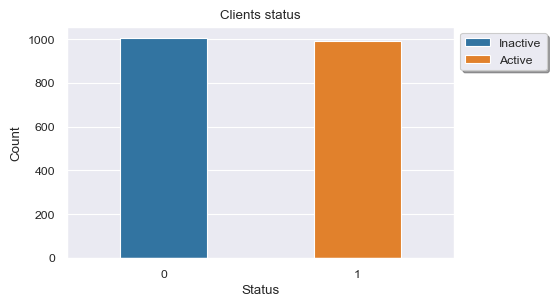

In [131]:
# Get statuses count
fig, ax= plt.subplots(figsize= (5,3))
sns.countplot(data= data, x= "status", width= 0.5,gap= 0.1,hue= "status", ax= ax)
ax.set_ylabel("Count")
ax.set_xlabel("Status")
ax.set_title("Clients status")
ax.legend(labels= ["Inactive", "Active"],
          shadow= True,
          loc='upper left',
          bbox_to_anchor=(1, 1))
plt.show()

The status column is a binary categorical variable where 0 is inactive and 1 is active. The plot shows an equal labels distribution in the status.

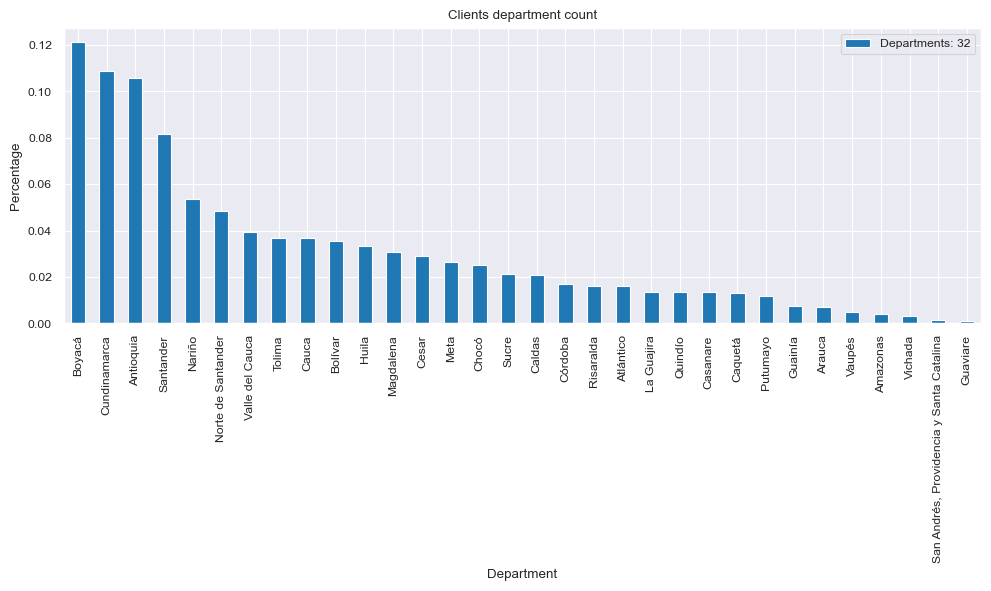

In [132]:
# Get department count in percentage
data["department_client"].value_counts(normalize = True).plot(kind= "bar", figsize= (10,6))
plt.xlabel("Department")
plt.legend(labels= [f"Departments: {data['department_client'].nunique()}"])
plt.ylabel("Percentage")
plt.title("Clients department count")
plt.tight_layout()

Client's department is a categorical variable highly cardinal, according the plot above, Boyaca, Cundinamarca and Antioquia are the most frequent departments in the data

## **5.2. Bivariate analysis**

### **5.2.1 Status analysis and department analysis**

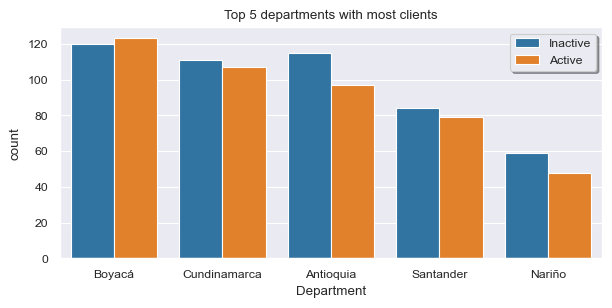

In [133]:
# Status according the department (top 10 most frequent departments)
frequent_departments = data["department_client"].value_counts().head(5).index.to_list()
tmp = data.loc[data["department_client"].isin(frequent_departments),:]

# Plot the result
fig,ax = plt.subplots(figsize= (7,3))
sns.countplot(data= tmp, x= "department_client", hue= "status", order = frequent_departments, ax= ax)
ax.legend(["Inactive", "Active"], shadow= True)
ax.set_title("Top 5 departments with most clients")
ax.set_xlabel("Department")
plt.show()

The plot shows that the deparments with highest client's amount present a similar status distribution

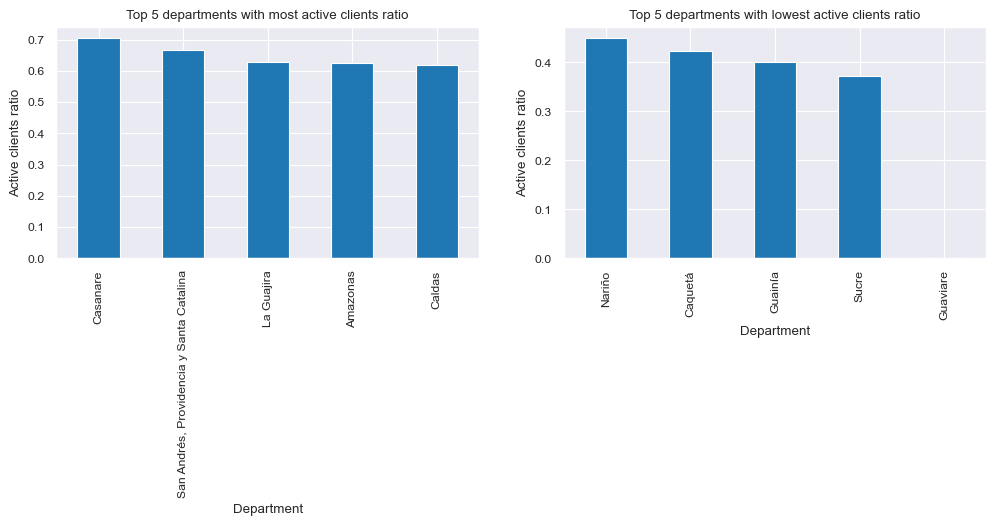

In [134]:
# Top 5 Departments with most active and inactive clients
tmp = data.groupby("department_client")["status"].mean().sort_values(ascending= False)

fig,ax = plt.subplots(nrows= 1, ncols= 2, figsize= (12,3))

# Active clients
tmp.head().plot(kind= "bar", ax= ax[0])
ax[0].set_xlabel("Department")
ax[0].set_ylabel("Active clients ratio")
ax[0].set_title("Top 5 departments with most active clients ratio")

# Inactive clients
tmp.tail().plot(kind= "bar", ax= ax[1])
ax[1].set_xlabel("Department")
ax[1].set_ylabel("Active clients ratio")
ax[1].set_title("Top 5 departments with lowest active clients ratio")

plt.show()

The plot shows the departments with highest and lowest active client's ratio, wich is calculated as follows 

$ACR_{department} = \frac{N_{active}}{N_{active} + N_{inactive}}$

Where $N_{active}$ and $N_{inactive}$ is the count of active and inactive clients respectively for a given department.

According to the plot, some deparments such as Casanare, La Guajira and Caldas, are the ones with the highest ACR, therefore it could be interesting to analyze those deparments by separate

### **5.2.2. Period and status analysis**

In [135]:
# Get features from datetime index
def get_datetime_features(df: pd.DataFrame) -> pd.DataFrame:
    data = df.copy()
    data["day_of_week"] = data.index.day_of_week
    data["day"] = data.index.day
    data["month"] = data.index.month
    data["year"] = data.index.year
    return data
    
# Plot aggregated data
def plot_data_aggregated(df: pd.DataFrame, var: str) -> None:
    data = df.copy()
    data = get_datetime_features(data)
    # Plots
    fig, ax= plt.subplots(nrows= 2, ncols= 2, figsize= (12,6))
    ax = ax.flatten()
    sns.lineplot(data= data, x= "day_of_week", y= var, ax= ax[0])
    sns.lineplot(data= data, x= "day", y= var, ax= ax[1])
    sns.lineplot(data= data, x= "month", y= var, ax= ax[2])
    sns.lineplot(data= data, x= "year", y= var, ax= ax[3])
    plt.tight_layout()

# Plot acf and pacf
def plot_acf_pacf(df: pd.Series | pd.DataFrame, var: str, n_lags= int) -> None:
    data = df.copy()
    fig, ax = plt.subplots(nrows= 1, ncols= 2, figsize= (10,3))
    plot_acf(x= data[var], lags= n_lags, ax= ax[0])
    plot_pacf(x= data[var], lags= n_lags, ax= ax[1])
    plt.tight_layout()

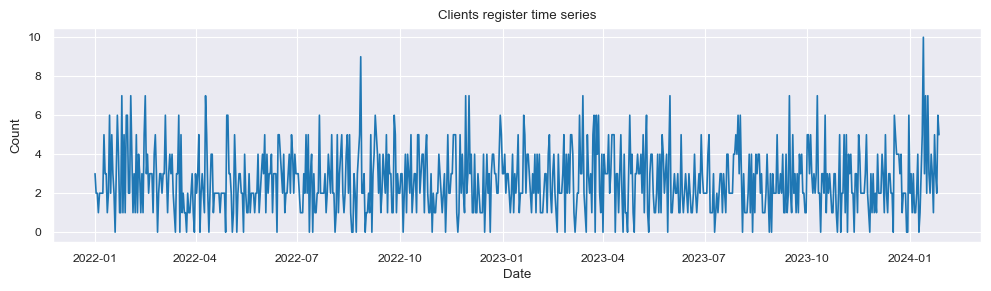

In [136]:
# Get number of clients per day
tmp = data.groupby(pd.Grouper(key= "period", freq= "D")).size()
tmp = pd.DataFrame(data= tmp, columns= ["count"])

# Plot time series
fig, ax = plt.subplots(figsize=(10,3))
sns.lineplot(data= tmp, x= "period", y= "count", ax= ax)
ax.set_title("Clients register time series")
ax.set_xlabel("Date")
ax.set_ylabel("Count")
plt.tight_layout()

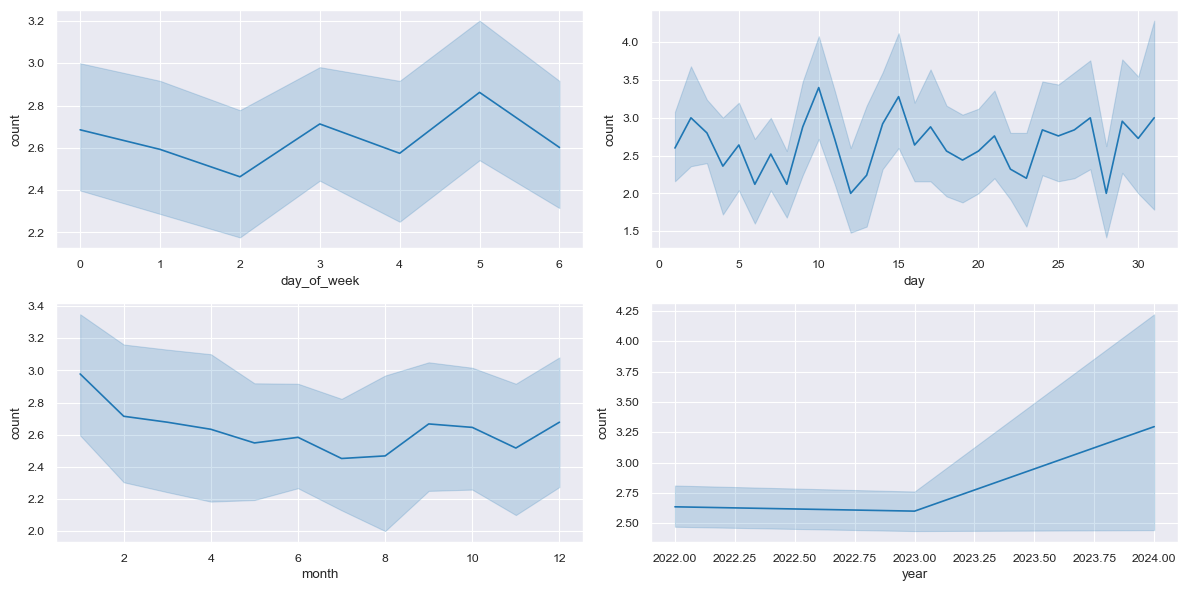

In [137]:
# Plot mean value per hour, day, day of the week, month and year
plot_data_aggregated(df= tmp, var= "count")

According the plots, it seems that there is some seasonality implicit in the data:
* Saturdays are in average the day of the with when occurs more registration process
* Also, the day 10 and 15 of each mont exhibits a peak in registration process.
* On the other hand, there is no relevant information in yearly seasonality

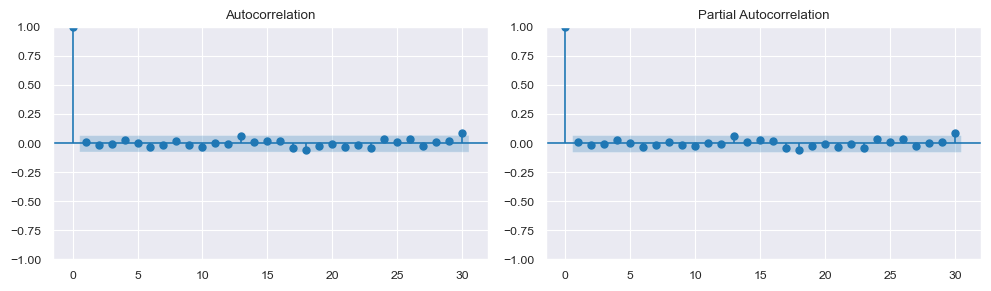

In [138]:
# Plot autocorrelation and partial autocorrelation lag plots
plot_acf_pacf(df= tmp, var= "count", n_lags= 30)

The plots does not reveal any dependecie or relationship between the data itself, therefore, lag variables could not be very important in order to identify patterns in clients registration

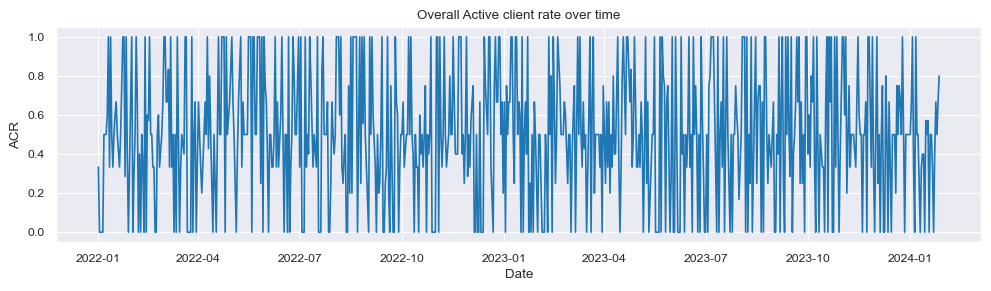

In [139]:
# Calculate the active client rate over time
acr = data.groupby(pd.Grouper(key= "period", freq= "D"))["status"].mean().to_frame()
acr = acr.rename(columns= {"status": "acr"})

# Plot time series
fig, ax = plt.subplots(figsize=(10,3))
sns.lineplot(data= acr, x= "period", y= "acr", ax= ax)
ax.set_title("Overall Active client rate over time")
ax.set_xlabel("Date")
ax.set_ylabel("ACR")
plt.tight_layout()

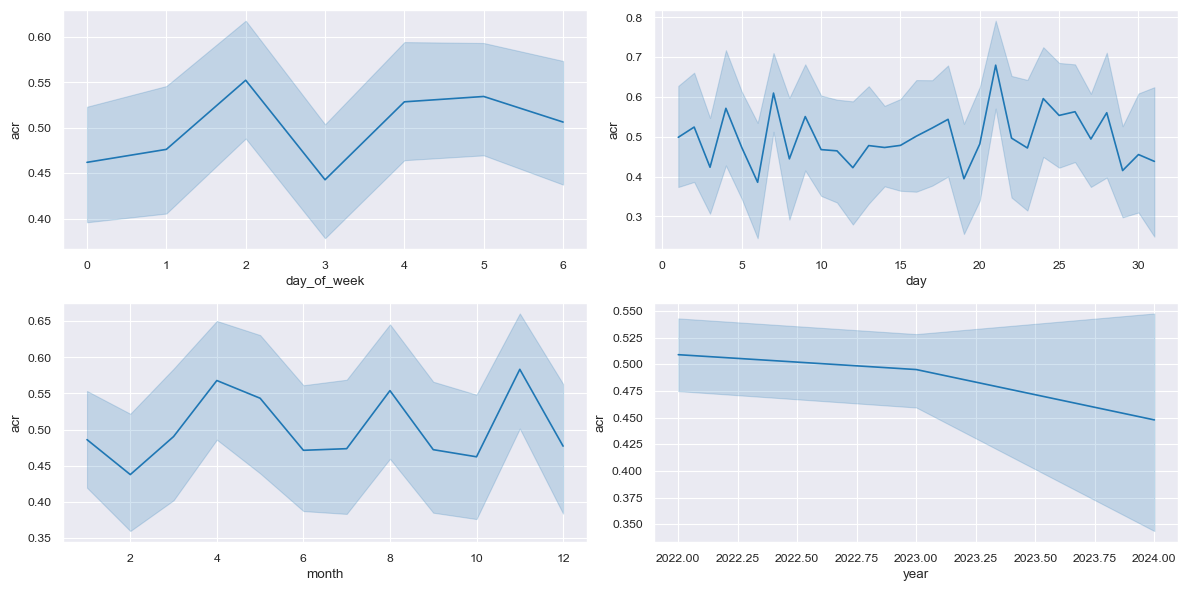

In [140]:
# Plot mean value per hour, day, day of the week, month and year
plot_data_aggregated(df= acr, var= "acr")